In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import lime
import lime.lime_tabular

/tmp/ipykernel_3455651/1979477410.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#data importation
import pandas as pd
import numpy as np

# Read the cleaned CSV file
fraud_data = pd.read_csv('CleanedFraudData.csv')

# Display the first few rows
fraud_data.head()


,Unnamed: 0,fraud_bool,income,name_email_similarity,salary,prev_address_months_count,current_address_months_count,customer_age,date_of_birth,days_since_request,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
0,2,0.0,0.8,0.996707,122830.0,9.0,14.0,40.0,1982-01-01,0.012316,...,200.0,0.0,INTERNET,22.730559,windows,0.0,1.0,0.0,January,aol.com
1,3,0.0,0.6,0.475100,83960.0,11.0,14.0,30.0,1990-09-05,0.006991,...,200.0,0.0,INTERNET,15.215816,linux,1.0,1.0,0.0,January,aol.com
2,6,0.0,0.2,0.773085,38585.0,22.0,4.0,40.0,1984-04-22,0.006919,...,200.0,0.0,INTERNET,28.199923,x11,1.0,1.0,0.0,January,zoho.com
3,8,0.0,0.3,0.523655,40031.0,21.0,2.0,30.0,1992-11-08,0.035206,...,200.0,0.0,INTERNET,5.329387,other,1.0,1.0,0.0,January,business.org
4,18,0.0,0.2,0.527751,37010.0,13.0,114.0,20.0,1999-09-25,0.003171,...,200.0,0.0,INTERNET,2.838194,windows,1.0,2.0,0.0,January,consulting.co


In [3]:
#shape of data
fraud_data.shape

(244191, 36)

In [4]:
# Data Types
fraud_data.dtypes

Unnamed: 0                            int64
fraud_bool                          float64
income                              float64
name_email_similarity               float64
salary                              float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
date_of_birth                        object
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                

In [5]:
# Removal of some redundant columns
fraud_data = fraud_data.drop(['name_email_similarity','salary','date_of_birth',
                              'zip_count_4w','income','Unnamed: 0'], axis=1)


In [6]:
# create cross tab for actual data
fraud_prop = pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop")/pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop").sum()
print(fraud_prop )

col_0         prop
fraud_bool        
0.0         0.9969
1.0         0.0031


In [7]:
pd.crosstab(index = fraud_data['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,243434
1.0,757


## Creating Train and Test data

In [8]:
train = fraud_data.groupby("fraud_bool").sample(n = 500, random_state = 1234)
test = fraud_data.loc[fraud_data.index.difference(train.index)]
train.head()

,fraud_bool,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,velocity_6h,velocity_24h,velocity_4w,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
156658,0.0,30.0,292.0,20.0,8.530328,31.862383,AA,10342.0,5998.0,5180.0,...,200.0,0.0,INTERNET,8.406942,other,0.0,1.0,0.0,May,yandex.com
63213,0.0,52.0,17.0,40.0,0.004717,-0.892632,AD,9698.0,4916.0,5617.0,...,200.0,0.0,INTERNET,3.214909,other,0.0,1.0,0.0,March,gmail.com
196385,0.0,20.0,0.0,30.0,1.221956,-0.683191,AB,3169.0,3642.0,4295.0,...,200.0,0.0,INTERNET,6.651120,other,1.0,1.0,0.0,July,yandex.com
97557,0.0,52.0,16.0,50.0,0.007483,-0.443474,AC,8974.0,5464.0,5191.0,...,1000.0,0.0,INTERNET,5.246280,linux,1.0,1.0,0.0,March,consulting.co
181264,0.0,24.0,4.0,20.0,0.030740,-1.001902,AC,7054.0,3243.0,4373.0,...,200.0,0.0,INTERNET,13.476022,other,0.0,1.0,0.0,June,finance.pro


In [9]:
pd.crosstab(index = train['fraud_bool'], columns = "count")



col_0,count
fraud_bool,
0.0,500
1.0,500


In [10]:
pd.crosstab(index = test['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,242934
1.0,257


In [11]:
# filling in number dtypes with median and flagging with missing 
train_o = train.copy()
num_cols = train_o.select_dtypes(include='number').columns

for col in num_cols:
    if train_o[col].isnull().any():
        # Create missing flag column
        train_o[f'{col}_was_missing'] = train_o[col].isnull().astype(int)

        # Impute with median
        median = train_o[col].median()
        train_o[col] = train_o[col].fillna(median)
print(train_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain'],
      dtype='object')


In [12]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(train_o.dtypes)


fraud_bool                          float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                    float64
phone_mobile_valid                  float64
bank_months_count                   float64
has_other_cards                     float64
proposed_credit_limit               float64
foreign_request                     float64
source                          

In [13]:
# creating X and Y and creating dummies for categorical data 
predictors = train_o.drop(columns=['fraud_bool'])
predictors = pd.get_dummies(predictors, drop_first=True)
predictors = predictors.astype(float)

X = predictors
y = train_o['fraud_bool']

In [14]:
# using Pearson's square to sort data and determine association, 
# Use p-value of 0.002 depending on the data siize
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

# Fit SelectKBest for Categorical Variables
selector = SelectKBest(score_func=chi2, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cat, y)

# Create a DataFrame with feature names, Chi2-scores, and p-values
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cat_features = scores_cat_df[scores_cat_df['p_value'] < 0.002]['Feature']

# Fit SelectKBest for Continous Variables
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cont, y)

# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cont_features = scores_cont_df[scores_cont_df['p_value'] < 0.002]['Feature']

# Create a new DataFrame with only those selected columns
X_reduced = X[selected_cat_features.tolist() + selected_cont_features.tolist()]

X_reduced.head()

,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,housing_status_BB,device_os_other,device_os_windows,month_August,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,device_distinct_emails_8w
156658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,292.0,20.0,31.862383,9.0,91.0,200.0,1.0
63213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,52.0,17.0,40.0,-0.892632,12.0,122.0,200.0,1.0
196385,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,20.0,0.0,30.0,-0.683191,16.0,253.0,200.0,1.0
97557,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,52.0,16.0,50.0,-0.443474,4.0,223.0,1000.0,1.0
181264,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,4.0,20.0,-1.001902,6.0,189.0,200.0,1.0


In [15]:
selected_cat_features

1         phone_home_valid
3          has_other_cards
4          foreign_request
5       keep_alive_session
7          payment_type_AC
9     employment_status_CB
13    employment_status_CF
14       housing_status_BB
21         device_os_other
22       device_os_windows
24            month_August
Name: Feature, dtype: object

In [16]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(X_reduced.dtypes)

phone_home_valid                    float64
has_other_cards                     float64
foreign_request                     float64
keep_alive_session                  float64
payment_type_AC                     float64
employment_status_CB                float64
employment_status_CF                float64
housing_status_BB                   float64
device_os_other                     float64
device_os_windows                   float64
month_August                        float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
intended_balcon_amount              float64
date_of_birth_distinct_emails_4w    float64
credit_risk_score                   float64
proposed_credit_limit               float64
device_distinct_emails_8w           float64
dtype: object


In [17]:
#remove variables with quasi separation 
def check_quasi_complete_separation(X, y):
    """
    Checks each categorical predictor in X for quasi-complete separation with respect to binary target y.
    
    Parameters:
    - X: pd.DataFrame of predictors (categorical variables)
    - y: pd.Series of binary target variable (e.g., 0/1 or True/False)
    
    Returns:
    - List of variable names that exhibit quasi-complete separation
    """
    problematic_vars = []

    for col in X.columns:
        ct = pd.crosstab(X[col], y)

        # Check if any category (row) has a zero in any outcome class
        if (ct == 0).any(axis=1).any():
            print(f"⚠️ Quasi-complete separation detected in '{col}'")
            print(ct)
            print()
            problematic_vars.append(col)

    return problematic_vars

In [18]:
# Create a new DataFrame with only those selected columns
X_cat_reduced = X_reduced[selected_cat_features]

problem_vars = check_quasi_complete_separation(X_cat_reduced, y)

In [19]:
X_reduced = X_reduced.drop(problem_vars, axis = 1)

## RandomForest


OOB Accuracy: 0.773

Top Feature Importances:
credit_risk_score                   0.133135
intended_balcon_amount              0.122554
prev_address_months_count           0.103824
date_of_birth_distinct_emails_4w    0.094250
current_address_months_count        0.092586
device_os_windows                   0.077807
keep_alive_session                  0.063604
customer_age                        0.056718
proposed_credit_limit               0.053000
phone_home_valid                    0.032596
device_distinct_emails_8w           0.032496
has_other_cards                     0.025137
device_os_other                     0.023917
payment_type_AC                     0.023577
housing_status_BB                   0.020803
dtype: float64


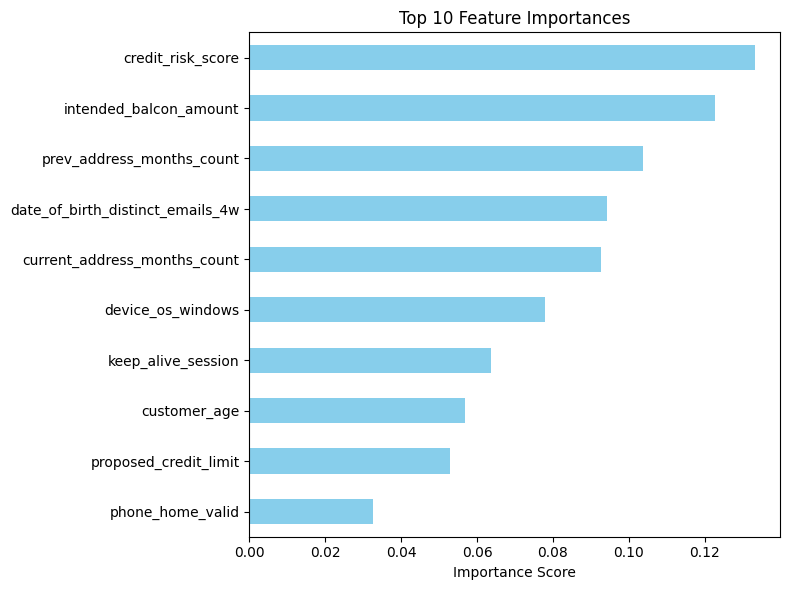

In [20]:
rf_cls = RandomForestClassifier(
    n_estimators=800,
    random_state=1234,
    oob_score=True,

)

rf_cls.fit(X_reduced, y)

# OOB accuracy 
print("\nOOB Accuracy:", rf_cls.oob_score_)

# Feature importances aligned with trained columns 
feature_importance = pd.Series(rf_cls.feature_importances_, index=X_reduced.columns).sort_values(ascending=False)
print("\nTop Feature Importances:")
print(feature_importance.head(15))

plt.figure(figsize=(8,6))
feature_importance.head(10).plot(kind='barh', color='skyblue', title="Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Model Tuning/Optimization

In [21]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# --- Step 1: Define classifier ---
rf = RandomForestClassifier(
    random_state=1234,
)

# --- Step 2: Define hyperparameter grid ---
param_grid = {
    'n_estimators': [100, 300, 500, 700],      # number of trees
    'max_depth': [None, 10, 20, 30],          # max depth of each tree
    'max_features': [3, 5, 7],                # number of features to consider at each split
    'min_samples_split': [2, 5, 10],          # min samples to split a node
    'min_samples_leaf': [1, 2, 4]             # min samples at a leaf node
}

# --- Step 3: Define cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# --- Step 4: Define scoring metric ---
scorer = make_scorer(f1_score)  # use F1 for imbalanced classification

# --- Step 5: Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,        # use all CPUs
    verbose=2
)

# --- Step 6: Fit on training data ---
grid_search.fit(X_reduced, y)  # X_selectedrf = your training features

# --- Step 7: Best hyperparameters and score ---
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# --- Step 8: Best estimator ---
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 Score: 0.7743683985727802


In [23]:
%%time

import optuna
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


# Step 1: Define the objective function
def objective(trial):
    # Define search space (equivalent to param_grid)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])
    max_features = trial.suggest_int('max_features', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 100, 800, step=100)
    
    # Create Random Forest Classifier
    rf_cls = RandomForestClassifier(
        max_depth=max_depth,
        max_features=max_features,
        n_estimators=n_estimators,
        random_state=1234,
    )
    
    # Stratified CV to preserve class proportions
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    # Evaluate using cross-validation (use 'accuracy', 'f1_weighted', or 'roc_auc')
    scores = cross_val_score(rf_cls, X_reduced, y, cv=cv, scoring='f1_weighted')
    return np.mean(scores)

# Step 2: Run the optimization
sampler = optuna.samplers.TPESampler(seed=1234)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Step 3: Best hyperparameters
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2026-01-23 22:52:37,422] A new study created in memory with name: no-name-0a920fea-de7f-40f1-9726-401ba7cba8d3


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-23 22:52:41,549] Trial 0 finished with value: 0.7680955145536399 and parameters: {'max_depth': 30, 'max_features': 6, 'n_estimators': 300}. Best is trial 0 with value: 0.7680955145536399.
[I 2026-01-23 22:52:47,409] Trial 1 finished with value: 0.7680640495811458 and parameters: {'max_depth': 20, 'max_features': 4, 'n_estimators': 500}. Best is trial 0 with value: 0.7680955145536399.
[I 2026-01-23 22:52:48,627] Trial 2 finished with value: 0.7761715591907757 and parameters: {'max_depth': 10, 'max_features': 5, 'n_estimators': 100}. Best is trial 2 with value: 0.7761715591907757.
[I 2026-01-23 22:52:51,660] Trial 3 finished with value: 0.7691393349709347 and parameters: {'max_depth': 10, 'max_features': 3, 'n_estimators': 300}. Best is trial 2 with value: 0.7761715591907757.
[I 2026-01-23 22:52:57,538] Trial 4 finished with value: 0.7700289442923758 and parameters: {'max_depth': None, 'max_features': 4, 'n_estimators': 500}. Best is trial 2 with value: 0.7761715591907757.
[I 

In [24]:
#RUN THIS ONLY AFTER BAYESIAN OPTIMIZATION

# Weights
weight_1 = 1
weight_0 = (243434 / 757) / (500 / 500)

# Random Forest Classifier
rf_cls2 = RandomForestClassifier(
    n_estimators=500,
    max_features=7,
    max_depth=10,
    random_state=1234,
    oob_score=True,
    class_weight={1: weight_1, 0: weight_0}
)

rf_cls2.fit(X_reduced, y)

,n_estimators,500
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


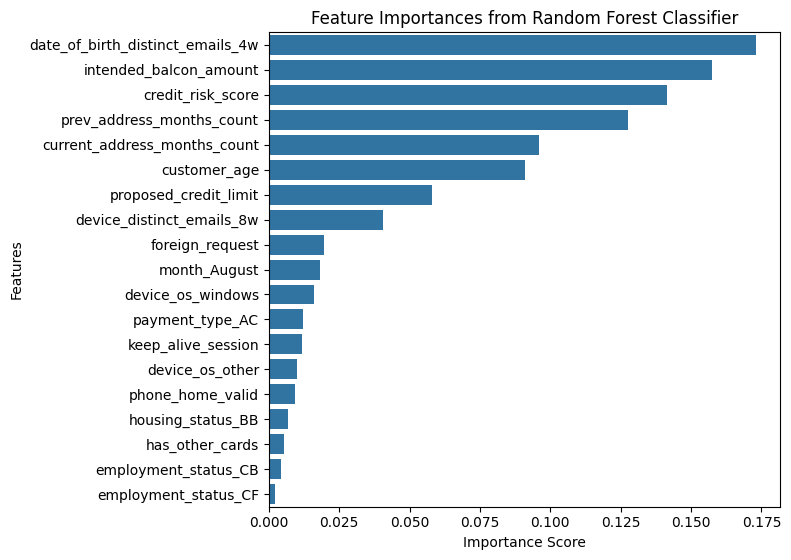

OOB Accuracy: 0.773


In [26]:
# Feature importances from the model after optimization 
import seaborn as sns

importances = rf_cls2.feature_importances_

feature_importances = pd.Series(importances, index=X_reduced.columns).sort_values(ascending=False)

plt.figure(figsize=(8, len(feature_importances) * 0.3))  # dynamic height
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances from Random Forest Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("OOB Accuracy:", rf_cls.oob_score_)

In [27]:
# --- Predict probabilities for the training set ---
train_o['pred_prob'] = rf_cls2.predict_proba(X_reduced)[:, 1]  # probability of class 1 (fraud)

# Optional: preview
train_o[['pred_prob']].head()

,pred_prob
156658,0.237661
63213,0.001381
196385,0.101508
97557,0.026414
181264,0.005820


In [28]:
from sklearn.metrics import roc_auc_score

# --- Ensure we have predicted probabilities ---
# Already stored in train_o['pred_prob']
train_o['p_hat'] = train_o['pred_prob']  # probability of fraud = 1

# --- Compute ROC-AUC (C-statistic) ---
auc = roc_auc_score(train_o['fraud_bool'], train_o['p_hat'])
print("C-statistic (AUC):", auc)

# --- Compute Somer's D ---
somer_d = 2 * auc - 1
print("Somer's D:", somer_d)


C-statistic (AUC): 0.8858
Somer's D: 0.7716000000000001


In [29]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- Ensure proper data types ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Check for both classes ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Compute Youden's J statistic ---
youden = pd.DataFrame({
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
})

# --- Sort by Youden's J ---
youden = youden.sort_values(by='Youden', ascending=False).reset_index(drop=True)

# --- Best cutoff ---
best_threshold = youden.loc[0, 'Cut-off']
print("Best threshold (Youden's J):", best_threshold)

# Optional: show top 5 thresholds
youden.head()


Best threshold (Youden's J): 0.04929020294305025


,TPR,FPR,Cut-off,Youden
0,0.784,0.174,0.049290,0.610
1,0.780,0.172,0.050165,0.608
2,0.786,0.178,0.048540,0.608
3,0.770,0.162,0.054278,0.608
4,0.780,0.174,0.050022,0.606


In [30]:
import pandas as pd

# --- Convert predicted probabilities to class labels ---
# Use 0.5 cutoff; you can also replace 0.5 with best_threshold if desired
train_o['pred'] = train_o['pred_prob'].map(lambda x: 1 if x >0.04929020294305025 else 0)

# --- Create confusion matrix ---
conf_matrix = pd.crosstab(train_o['fraud_bool'], train_o['pred'],
                          rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 Predicted    0    1
Actual             
0.0        413   87
1.0        109  391


In [31]:
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np

# --- True labels and predicted probabilities ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Business Costs ---
C_FN = 1200  # Cost of false negative (missed fraud)
C_FP_values = np.arange(700, 1001, 100)  # Costs of false positive (700 → 1000)

# --- Check for both classes ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Base counts ---
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# --- Build DataFrame to store results ---
results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# --- Compute cost for each FP cost level ---
for C_FP in C_FP_values:
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )

# --- Find best threshold for each FP cost ---
best_thresholds = []
for C_FP in C_FP_values:
    col = f'Cost_FP{C_FP}'
    idx_min = results[col].idxmin()
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': results.loc[idx_min, 'Threshold'],
        'Min_Cost': results.loc[idx_min, col],
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

print("Optimal thresholds by false positive cost:")
print(best_df)


Optimal thresholds by false positive cost:
   C_FP  Best_Threshold  Min_Cost    TPR    FPR
0   700         0.04929  190500.0  0.784  0.174
1   800         0.04929  199200.0  0.784  0.174
2   900         0.04929  207900.0  0.784  0.174
3  1000         0.04929  216600.0  0.784  0.174


✅ Optimal thresholds and cost savings vs baseline (threshold = 0.5):

   C_FP  Best_Threshold  Baseline_Cost  Min_Cost   Savings   TPR   FPR
0   700            0.05       376800.0  190500.0  186300.0  0.78  0.17
1   800            0.05       376800.0  199200.0  177600.0  0.78  0.17
2   900            0.05       376800.0  207900.0  168900.0  0.78  0.17
3  1000            0.05       376800.0  216600.0  160200.0  0.78  0.17


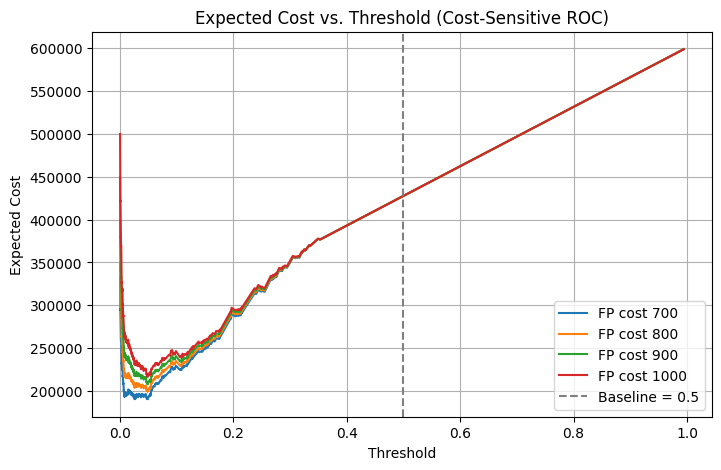

In [32]:
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Inputs ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Business Costs ---
C_FN = 1200                        # Cost of missing a fraud
C_FP_values = np.arange(700, 1001, 100)  # Cost range for false positives (700–1000)
baseline_threshold = 0.5           # Current operational cutoff

# --- Check for both classes ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# --- Compute cost and compare to baseline ---
best_thresholds = []

# Baseline performance at threshold 0.5
baseline_idx = np.argmin(np.abs(thresholds - baseline_threshold))
baseline_tpr = tpr[baseline_idx]
baseline_fpr = fpr[baseline_idx]

for C_FP in C_FP_values:
    # Expected cost at each threshold
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )
    
    # Baseline cost
    baseline_cost = (
        (C_FP * baseline_fpr * total_neg) + 
        (C_FN * (1 - baseline_tpr) * total_pos)
    )
    
    # Minimum cost and corresponding threshold
    idx_min = results[f'Cost_FP{C_FP}'].idxmin()
    min_cost = results.loc[idx_min, f'Cost_FP{C_FP}']
    best_threshold = results.loc[idx_min, 'Threshold']
    
    # Savings = baseline_cost - min_cost
    savings = baseline_cost - min_cost
    
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': best_threshold,
        'Baseline_Cost': baseline_cost,
        'Min_Cost': min_cost,
        'Savings': savings,
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

# --- Display results ---
print("✅ Optimal thresholds and cost savings vs baseline (threshold = 0.5):\n")
print(best_df.round(2))

# --- Plot cost curves ---
plt.figure(figsize=(8, 5))
for C_FP in C_FP_values:
    plt.plot(results['Threshold'], results[f'Cost_FP{C_FP}'], label=f'FP cost {C_FP}')
plt.axvline(baseline_threshold, color='gray', linestyle='--', label='Baseline = 0.5')
plt.xlabel('Threshold')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs. Threshold (Cost-Sensitive ROC)')
plt.legend()  # fixed legend
plt.grid(True)
plt.show()


✅ Cost-Optimized Threshold (C_FP = 820)
Optimal Threshold : 0.0493
True Positive Rate: 0.7840
False Positive Rate: 0.1740
Minimum Expected Cost: $200,940.00


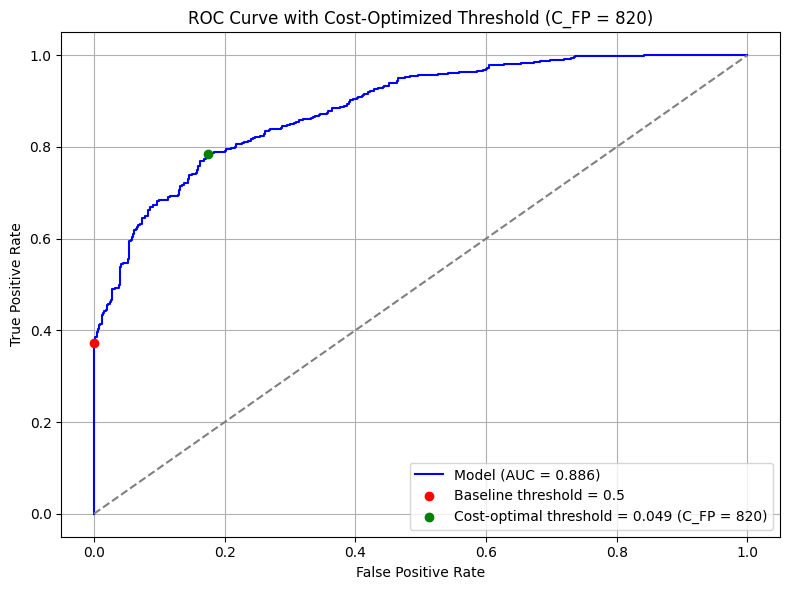

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- True labels and predicted probabilities ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- ROC curve for all thresholds ---
fpr_model, tpr_model, thresholds_model = roc_curve(y_true, y_score)
auc_model = roc_auc_score(y_true, y_score)

# --- Business cost setup ---
C_FN = 1200   # Cost of false negative (missed fraud)
C_FP = 820    # Cost of false positive (wrongly flagged)

# --- Class counts ---
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# --- Compute total expected business cost for each threshold ---
costs = (C_FP * fpr_model * total_neg) + (C_FN * (1 - tpr_model) * total_pos)

# --- Identify threshold minimizing total cost ---
idx_min = np.argmin(costs)
optimal_threshold = thresholds_model[idx_min]
optimal_fpr = fpr_model[idx_min]
optimal_tpr = tpr_model[idx_min]
optimal_cost = costs[idx_min]

# --- Print results ---
print("✅ Cost-Optimized Threshold (C_FP = 820)")
print(f"Optimal Threshold : {optimal_threshold:.4f}")
print(f"True Positive Rate: {optimal_tpr:.4f}")
print(f"False Positive Rate: {optimal_fpr:.4f}")
print(f"Minimum Expected Cost: ${optimal_cost:,.2f}")

# --- Plot ROC curve ---
plt.figure(figsize=(8, 6))

# Standard ROC curve
plt.plot(fpr_model, tpr_model, label=f"Model (AUC = {auc_model:.3f})", color='blue')

# Baseline threshold = 0.5 marker
baseline_idx = np.argmin(np.abs(thresholds_model - 0.5))
plt.scatter(
    fpr_model[baseline_idx],
    tpr_model[baseline_idx],
    color='red',
    label="Baseline threshold = 0.5",
    zorder=5
)

# Cost-optimized threshold marker
plt.scatter(
    optimal_fpr,
    optimal_tpr,
    color='green',
    label=f"Cost-optimal threshold = {optimal_threshold:.3f} (C_FP = 820)",
    zorder=5
)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Cost-Optimized Threshold (C_FP = 820)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


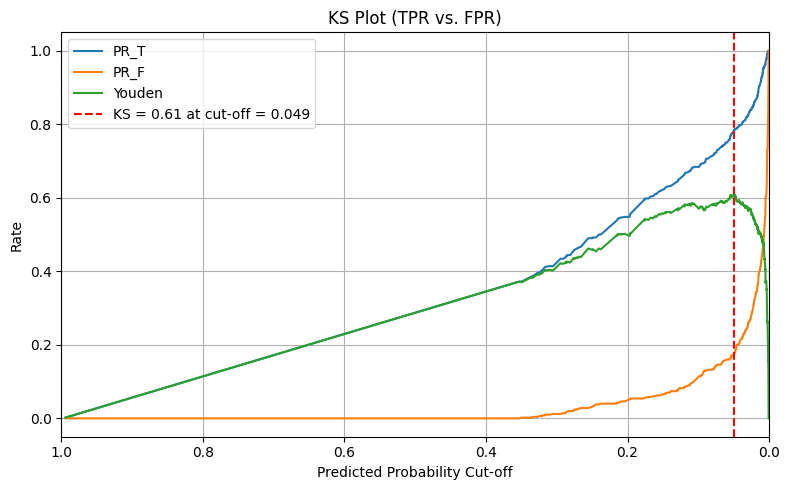

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# --- True labels and predicted probabilities ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Build Youden DataFrame ---
youden = pd.DataFrame({
    'Cut-off': thresholds,
    'TPR': tpr,
    'FPR': fpr,
    'Youden': tpr - fpr
})

# Sort by Cut-off ascending
youden = youden.sort_values(by='Cut-off', ascending=True)

# Prepare for plotting (melt for seaborn)
ks_stat = youden.rename(columns={'TPR': 'PR_T', 'FPR': 'PR_F'})
ks_stat = ks_stat.melt(id_vars='Cut-off', var_name='PR', value_name='value')

# KS statistic and cutoff
ks_val = youden['TPR'].sub(youden['FPR']).max()
ks_cutoff = youden.loc[(youden['TPR'] - youden['FPR']).idxmax(), 'Cut-off']

# --- Plot KS curve ---
plt.figure(figsize=(8, 5))
sns.lineplot(x='Cut-off', y='value', hue='PR', data=ks_stat)
plt.xlim(1, 0)  # decreasing threshold
plt.title("KS Plot (TPR vs. FPR)")
plt.xlabel("Predicted Probability Cut-off")
plt.ylabel("Rate")
plt.grid(True)
plt.axvline(x=ks_cutoff, linestyle='--', color='red', label=f'KS = {ks_val:.2f} at cut-off = {ks_cutoff:.3f}')
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Arrays to store metrics
precision = []
recall = []
f1score = []

# Evaluate metrics across 0 → 0.99 thresholds
for y in range(100):
    cutoff = y / 100
    train_o['pred'] = (train_o['p_hat'] > cutoff).astype(int)
    
    precision.append(precision_score(train_o['fraud_bool'], train_o['pred']))
    recall.append(recall_score(train_o['fraud_bool'], train_o['pred']))
    f1score.append(f1_score(train_o['fraud_bool'], train_o['pred']))

# Create DataFrame
f1_s = pd.DataFrame({
    'Cut-off': np.arange(0, 1, 0.01),
    'Precision': precision,
    'Recall': recall,
    'F1': f1score
})

# Sort by F1 descending to find best threshold
best_f1 = f1_s.sort_values(by='F1', ascending=False)
print("Top thresholds by F1 score:\n")
print(best_f1.head(10))


Top thresholds by F1 score:

    Cut-off  Precision  Recall        F1
5      0.05   0.817610   0.780  0.798362
4      0.04   0.788538   0.798  0.793241
3      0.03   0.763941   0.822  0.791908
2      0.02   0.725589   0.862  0.787934
6      0.06   0.825991   0.750  0.786164
1      0.01   0.677843   0.930  0.784148
7      0.07   0.834091   0.734  0.780851
8      0.08   0.843972   0.714  0.773564
11     0.11   0.875648   0.676  0.762980
10     0.10   0.861461   0.684  0.762542


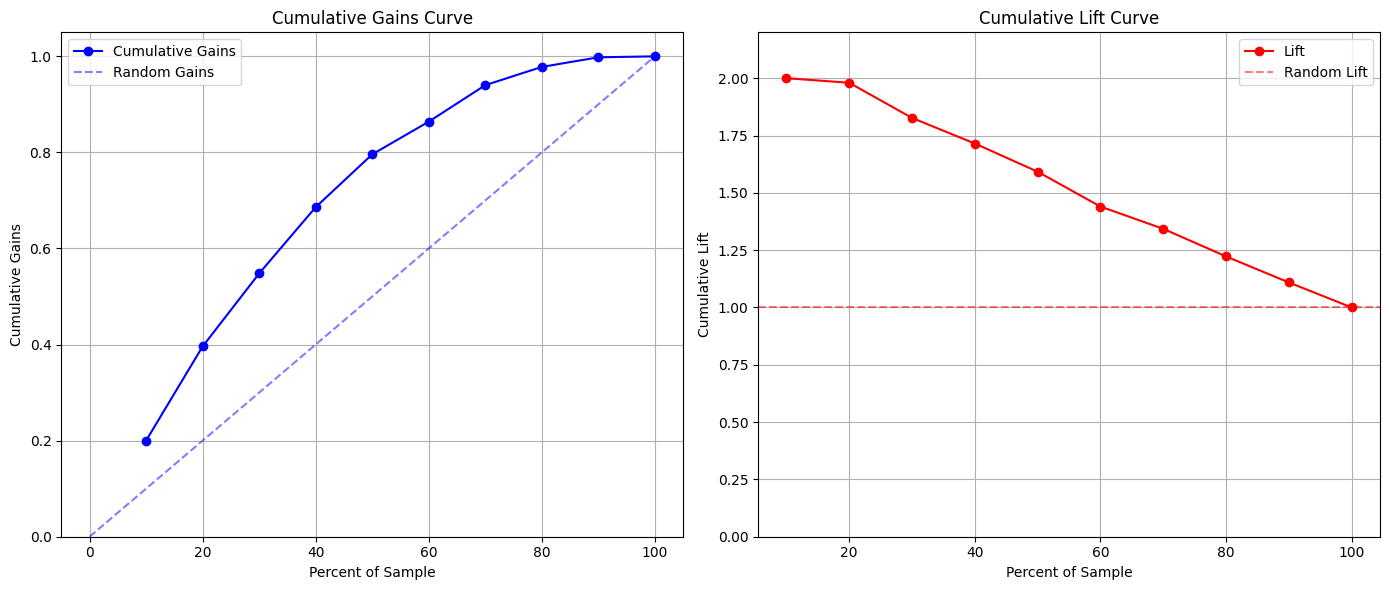

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lift_and_gains(y_true, y_proba, n_bins=10):
    """
    Plot Lift and Cumulative Gains curves.

    Parameters:
    - y_true: array-like, true binary labels (0/1)
    - y_proba: array-like, predicted probabilities for the positive class
    - n_bins: number of bins/deciles to split data
    """
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    
    # Sort descending by predicted probability
    df = df.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
    
    # Cumulative totals
    df['cum_total'] = np.arange(1, len(df) + 1)
    df['cum_positives'] = df['y_true'].cumsum()
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    # Cumulative Gains: % positives captured vs % samples
    df['cum_gains'] = df['cum_positives'] / total_positives
    
    # Lift: (cumulative gains) / (cumulative % of sample)
    df['cum_lift'] = df['cum_gains'] / (df['cum_total'] / total_samples)
    
    # Sample points for plotting (deciles)
    cutoffs = np.linspace(0, total_samples, n_bins + 1, dtype=int)[1:]  # skip 0
    plot_points = df.loc[cutoffs - 1, ['cum_total', 'cum_gains', 'cum_lift']].copy()
    plot_points['percent_samples'] = plot_points['cum_total'] / total_samples * 100
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Cumulative Gains Curve
    axes[0].plot(plot_points['percent_samples'], plot_points['cum_gains'], marker='o', color='blue', label='Cumulative Gains')
    axes[0].plot([0, 100], [0, 1], linestyle='--', color='blue', alpha=0.5, label='Random Gains')
    axes[0].set_xlabel('Percent of Sample')
    axes[0].set_ylabel('Cumulative Gains')
    axes[0].set_title('Cumulative Gains Curve')
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(True)
    axes[0].legend()
    
    # Lift Curve
    axes[1].plot(plot_points['percent_samples'], plot_points['cum_lift'], marker='o', color='red', label='Lift')
    axes[1].axhline(1, linestyle='--', color='red', alpha=0.5, label='Random Lift')
    axes[1].set_xlabel('Percent of Sample')
    axes[1].set_ylabel('Cumulative Lift')
    axes[1].set_title('Cumulative Lift Curve')
    axes[1].set_ylim(0, plot_points['cum_lift'].max() * 1.1)
    axes[1].grid(True)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_lift_and_gains(train_o['fraud_bool'], train_o['p_hat'])


## Testing 

In [37]:
test_o= test.copy()
num_cols_test = test_o.select_dtypes(include='number').columns

for col in num_cols_test:
    if test_o[col].isnull().any():
        # Create missing flag column
        test_o[f'{col}_was_missing'] = test_o[col].isnull().astype(int)

        # Impute with median
        median = test_o[col].median()
        test_o[col] = test_o[col].fillna(median)
print(test_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain', 'velocity_6h_was_missing'],
      dtype='object')


In [38]:
predictors_test = test_o.drop(columns=['fraud_bool'])
predictors_test = pd.get_dummies(predictors_test, drop_first=True)
predictors_test = predictors_test.astype(float)

train_columns = X_reduced.columns 

# Add missing columns in test set
for col in train_columns:
    if col not in predictors_test.columns:
        predictors_test[col] = 0

# Remove extra columns not in training
predictors_test = predictors_test[train_columns]

# Now X_test matches X_train exactly
X_test = predictors_test
y_test = test_o['fraud_bool']
X_test.head()

,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,housing_status_BB,device_os_other,device_os_windows,month_August,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,device_distinct_emails_8w
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,14.0,40.0,-1.490386,11.0,89.0,200.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,14.0,30.0,-1.863101,13.0,90.0,200.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,4.0,40.0,-0.544676,8.0,72.0,200.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.0,2.0,30.0,-0.955737,10.0,35.0,200.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13.0,114.0,20.0,-0.848347,18.0,49.0,200.0,2.0


In [39]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, confusion_matrix, classification_report
)
import pandas as pd

def evaluate_classification(model, X, y, model_name, threshold=0.5):
    """
    Compute classification metrics for a given model and threshold.
    
    Parameters:
    - model: fitted model with predict_proba
    - X: features
    - y: true binary labels
    - model_name: string label for output
    - threshold: probability cutoff for binary prediction
    """
    # Predicted probabilities for positive class
    y_prob = model.predict_proba(X)[:, 1]
    
    # Convert probabilities to binary predictions using threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Compute metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, digits=4)
    
    # Display results
    print(f"\n====== {model_name} CLASSIFICATION PERFORMANCE ======")
    print(f"Threshold: {threshold:.6f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(report)
    
    # Return metrics as dictionary for further analysis
    metrics_dict = {
        'Model': model_name,
        'Threshold': threshold,
        'Accuracy': accuracy,
        'ROC-AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ConfusionMatrix': cm,
        'ClassificationReport': report
    }
    
    return metrics_dict


In [40]:
metrics_Random = evaluate_classification(rf_cls2, X_test, y_test, "RandomForest", threshold=0.04929020294305025)



====== RandomForest CLASSIFICATION PERFORMANCE ======
Threshold: 0.049290
Accuracy : 0.6710
ROC-AUC  : 0.7383
Precision: 0.0022
Recall   : 0.6732
F1 Score : 0.0043

Confusion Matrix:
[[163004  79930]
 [    84    173]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9995    0.6710    0.8029    242934
         1.0     0.0022    0.6732    0.0043       257

    accuracy                         0.6710    243191
   macro avg     0.5008    0.6721    0.4036    243191
weighted avg     0.9984    0.6710    0.8021    243191



<Figure size 1000x600 with 0 Axes>

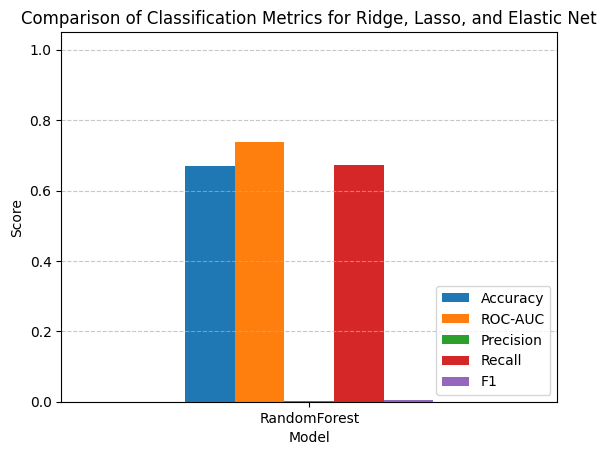

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Collect metrics in a DataFrame ---
metrics_df = pd.DataFrame([
    metrics_Random
])

# Select only numeric metrics for plotting
plot_metrics = metrics_df[['Model', 'Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1']]

# Set 'Model' as index
plot_metrics.set_index('Model', inplace=True)

# --- Plot ---
plt.figure(figsize=(10,6))
plot_metrics.plot(kind='bar', rot=0)
plt.title("Comparison of Classification Metrics for Ridge, Lasso, and Elastic Net")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()


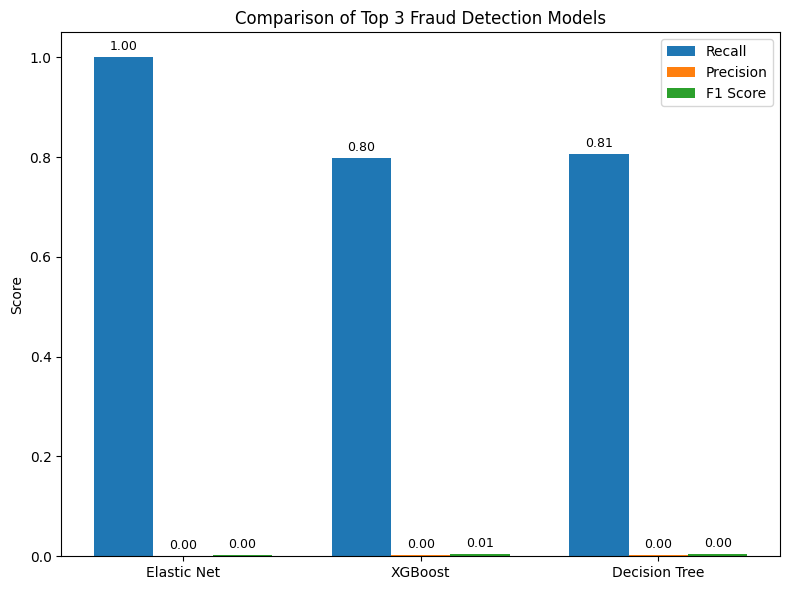

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Top 3 models metrics ---
metrics_data = {
    'Model': ['Elastic Net', 'XGBoost', 'Decision Tree'],
    'Recall': [1.0, 0.7977, 0.8054],
    'Precision': [0.0011, 0.0026, 0.0022],
    'F1 Score': [0.0021, 0.0052, 0.0045]
}

df_metrics = pd.DataFrame(metrics_data)

# --- Plot ---
x = np.arange(len(df_metrics['Model']))  # label locations
width = 0.25  # width of bars

fig, ax = plt.subplots(figsize=(8,6))

rects1 = ax.bar(x - width, df_metrics['Recall'], width, label='Recall', color='#1f77b4')
rects2 = ax.bar(x, df_metrics['Precision'], width, label='Precision', color='#ff7f0e')
rects3 = ax.bar(x + width, df_metrics['F1 Score'], width, label='F1 Score', color='#2ca02c')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('Comparison of Top 3 Fraud Detection Models')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Model'])
ax.legend()
ax.set_ylim(0, 1.05)  # scale to 1 for Recall

# Show values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()
